<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Regularization and Optimization for Neural Networks

_Authors:_ Matt Brems, Tim Book, Justin Pounders with minor edits by Adi Bronshtein & Noah Christiansen


### Learning Objectives

By the end of the lesson, students should be able to:
- Explain how L1/L2, dropout, and early stopping regularization work and implement these methods in Keras
- Implement methods for speeding up learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Load the data

    This data comes from the Orange Telecom's Churn Dataset, which consists of cleaned customer activity data (features), along with a churn label specifying whether a customer canceled the subscription.

You can find more information about this dataset in the [**Data Dictionary**](https://www.kaggle.com/mnassrib/telecom-churn-datasets?select=churn-bigml-80.csv)

In [2]:
data = pd.read_csv('../data/cell_phone_churn.csv')
data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
data.shape

(3333, 20)

In [4]:
data.corr()["churn"].sort_values()

vmail_message    -0.089728
intl_calls       -0.052844
night_calls       0.006141
area_code         0.006174
eve_calls         0.009233
account_length    0.016541
day_calls         0.018459
night_mins        0.035493
night_charge      0.035496
intl_mins         0.068239
intl_charge       0.068259
eve_charge        0.092786
eve_mins          0.092796
day_charge        0.205151
day_mins          0.205151
custserv_calls    0.208750
churn             1.000000
Name: churn, dtype: float64

In [5]:
# Drop state column
data.drop(columns = ['state'], inplace = True)

data = pd.get_dummies(data, columns = ['area_code'])

# Binarize intl_plan and vmail_plan columns
data['intl_plan'] = data['intl_plan'].replace({'yes':1, 'no':0})
data['vmail_plan'] = data['vmail_plan'].replace({'yes':1, 'no':0})

In [6]:
data.shape

(3333, 21)

In [7]:
data.head()

,account_length,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,...,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn,area_code_408,area_code_415,area_code_510
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,91,11.01,10.0,3,2.70,1,False,0,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,103,11.45,13.7,3,3.70,1,False,0,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,104,7.32,12.2,5,3.29,0,False,0,1,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,89,8.86,6.6,7,1.78,2,False,1,0,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,121,8.41,10.1,3,2.73,3,False,0,1,0


In [8]:
# Split into X and y
X = data.drop(columns='churn')
y = data['churn'].astype(int) 

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=12)

# Scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [9]:
# Get the baseline
y_test.value_counts(normalize=True)

0    0.854916
1    0.145084
Name: churn, dtype: float64

## Build a simple neural net to model churn

Let's build this:

- a dense network,
- one input layer,
- two hidden layers
  - slightly smaller than input layer
  - ReLU activation
- single node output (for binary classification)

<details><summary>What activation function will we use for our output layer here?</summary>

- Sigmoid activation, since we are doing binary classification.

Fun fact: If we dropped the hidden layer, this model would just be logistic regression!  Can you prove that to yourself?
</details>

In [10]:
# Input shape
X_train_sc[0].shape

(20,)

In [11]:
# Insert model here
model = Sequential()

model.add(Dense(32, input_shape=X_train_sc[0].shape, activation='relu')) # Input & 1st layer
model.add(Dense(16, activation='relu')) # 2nd hidden layer
model.add(Dense(1, activation='sigmoid')) # Output layer

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile it
## loss function is Binary Cross Entropy, optimizer is adam
model.compile(loss='bce', optimizer='adam', metrics=['acc'])

In [14]:
# Fit it
results = model.fit(X_train_sc, y_train, 
                   epochs=100, # 100 epochs because we want it to overfit
                   validation_data=(X_test_sc, y_test),
                   verbose=0, # No output will be printed!
                   batch_size=256) ## batch size = 256 because dataset isn't that large

In [15]:
# Look, Ma, the machine is learning!

In [16]:
# The history object
results.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

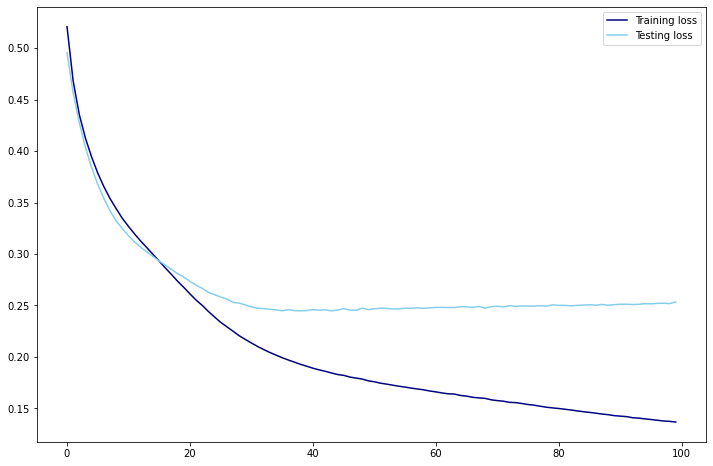

In [17]:
# Visualize the loss
train_loss = results.history['loss']
test_loss = results.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

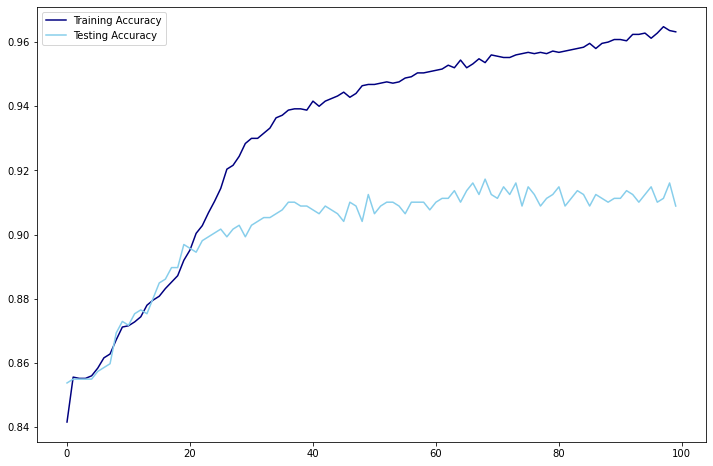

In [18]:
# Visualize the accuracy
train_acc = results.history['acc']
test_acc = results.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Accuracy', color='navy')
plt.plot(test_acc, label='Testing Accuracy', color='skyblue')
plt.legend();

In [19]:
## What was our final training and testing accuracy?
results.history['acc'][-1], results.history['val_acc'][-1]

(0.9631852507591248, 0.9088729023933411)

![](../assets/overkill.jpg)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


<a id='l1'></a>
## Regularization Method 1: $\mathcal{l}_1$ and $\mathcal{l}_2$
---
Just as we did with linear models, we can use $\mathcal{l}_1$ (LASSO) and $\mathcal{l}_2$ (Ridge) regularization on our neural networks.

Recall from our notation:

* $J(\theta) = L(\mathbf{y}, \hat{\mathbf{y}})$ is the value of the loss function with respect to...
* $\theta$, the list of _all_ model coefficients (all weights and biases).

We regularize our neural networks by adding a penalty term to our loss function:

$$ \text{minimize } J(\theta) + \lambda \|\theta\|_2^2 $$

This has the effect of penalizing our parameters $\theta$ by shrinking them, hence bartering in the bias-variance tradeoff by (hopefully) reducing variance by adding bias. Although it is rarely done, **Keras actually gives us the opportunity to penalize the weights at different layers by different amounts.**

## Which to pick: $\mathcal{l}_1$ or $\mathcal{l}_2$?
Recall the key difference: $\mathcal{l}_1$ penalties perform _selection_. That is, they often zero out parameters when they're small enough. While this sounds appealing, $\mathcal{l}_2$ is used almost exclusively. It's done so often, that deep learning practitions give it a special name: **weight decay**.

In [21]:
# Import regularizers
from tensorflow.keras.regularizers import l2

# Model
model_l2 = Sequential()

model_l2.add(Dense(32, input_shape=X_train_sc[0].shape,
                   activation='relu',
                   kernel_regularizer=l2(0.01))) # add l2 regularizer (strength - generally between 0 and 0.1)
model_l2.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01))) # we usually apply same regularization to each hidden layer
model_l2.add(Dense(1, activation='sigmoid'))

# Compile it
model_l2.compile(loss='bce', optimizer='adam', metrics=['acc'])

# Fit it
results_l2 = model_l2.fit(X_train_sc, y_train, 
                          validation_data=(X_test_sc, y_test),
                          epochs=100, batch_size=256,
                          verbose=0)

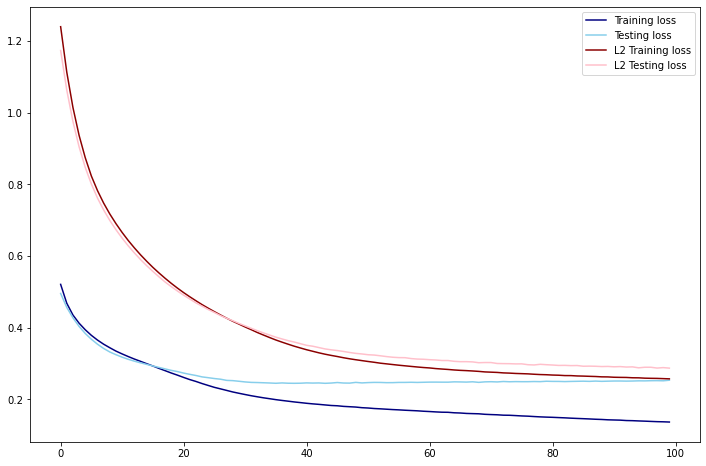

In [22]:
# Visualize loss
train_loss_l2 = results_l2.history['loss']
test_loss_l2 = results_l2.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

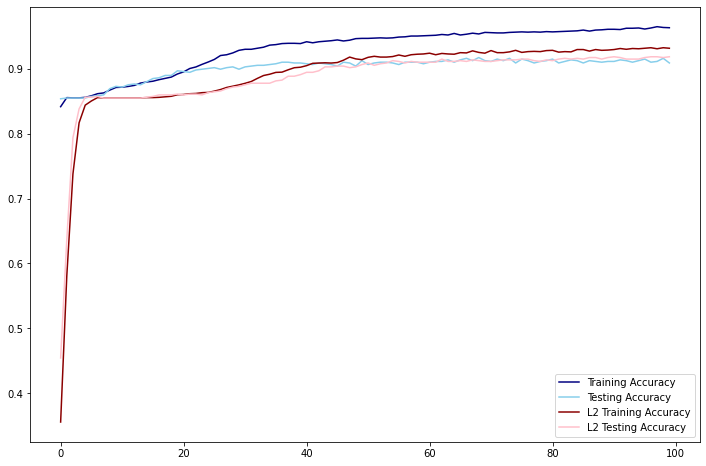

In [23]:
# Visualize accuracy
train_acc_l2 = results_l2.history['acc']
test_acc_l2 = results_l2.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Accuracy', color='navy')
plt.plot(test_acc, label='Testing Accuracy', color='skyblue')
plt.plot(train_acc_l2, label='L2 Training Accuracy', color='darkred')
plt.plot(test_acc_l2, label='L2 Testing Accuracy', color='pink')
plt.legend();

In [24]:
## What was our final training and testing accuracy?
results_l2.history['acc'][-1], results_l2.history['val_acc'][-1]

(0.9315726161003113, 0.918465256690979)

## Keras Resources
- [Keras Regularization Documentation](https://keras.io/regularizers/)
- [Kernel vs. Activity Regularizers](https://stats.stackexchange.com/questions/383310/what-is-the-difference-between-kernel-bias-and-activity-regulizers-and-when-t)

## Tensorflow Resources
- [Implementation in Tensorflow](https://www.tensorflow.org/versions/r0.12/api_docs/python/contrib.layers/regularizers)
- [Example in Tensorflow](http://www.ritchieng.com/machine-learning/deep-learning/tensorflow/regularization/)

<a id='dropout'></a>
## Regularization Method 2: Dropout
---
There's another method of regularizing our terms that is specifically designed for neural networks, called **dropout regularization.**

Let's say we've constructed a neural network. We've decided on the number of layers we want and the number of nodes in each layer. (We might say that we've decided on the **topology** or **structure** of our network.)

![](../assets/original_nn.jpeg)

However, a densely connected network like this will almost certainly overfit. Our network is learning a parameter for every single connection.

> In the above example, we have 55 parameters being learned - and this is a very simple network, all things considered.

> We can overcome this by using **dropout regularization**. 

In dropout regularization, we randomly **drop** units (nodes) in our neural network ***during our training phase only***. We assign a probability of each node disappearing. Then, we essentially perform a coinflip for every node to turn that node "on" or "off."

Let's go through an example to illustrate this: For simplicity, we'll say we've assigned a 0.5 probability of keeping to every node in the network above. Then, for every node, we flip a coin, and if the coin lands on heads, the node remains, if it lands on tails, the node disappears. After we've done this for every node, we're left with a new network that looks something like this:

![](../assets/after_dropout.jpeg)

<!--
Image sources: https://pgaleone.eu/deep-learning/regularization/2017/01/10/anaysis-of-dropout/
Also, it seems, this site: http://cs231n.github.io/neural-networks-2/
-->

Let's explicitly lay out the general workflow you would follow:

1. Specify the topology of your neural network.
2. Initialize your weights and biases.
3. Specify the "keeping probabilities" for every node. (Generally, we'll assign the same probability to all nodes in each layer and usually the same probability to all hidden layers.)
4. Perform a "coin flip" for each node and drop out the chosen nodes.
5. Run through one epoch of training.
6. Repeat steps 4 and 5 for each epoch of training.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif)

<details><summary>If I drop out a node during one of my epochs, does it disappear from my final network?</summary>

- No!
</details>

#### So, what does this do?
<!-- <br/> -->
The intuition behind dropout is that, since each node has a probability of disappearing at any time, the neural network is disincentivized from allocating too much power to any one weight. It has a similar effect as imposing an L2 penalty: the magnitude of our weights shrinks.

<details><summary>What might be some potential problems with doing this?</summary>

- expected values of nodes changes
- induces bias
</details>

So we've now run through every epoch of our training phase and we're ready to apply our neural network to our validation or testing data.

<details><summary>Are we going to apply dropout to this data as well?</summary>

- No!
</details>

#### Best practices:

- Don't set any keeping probabilities for layers you where you don't want to drop any nodes.

<details><summary>What might be examples of these layers?</summary>

- Input layers
- Output layers
</details>

- You'll generally want to specify a single keeping probability and all the layers on which you want to apply dropout, instead of specifying different keeping probabilities for each layer.

In [25]:
from tensorflow.keras.layers import Dropout

# Build a model using Dropout
# Model
model_dropout = Sequential()

model_dropout.add(Dense(32, input_shape=X_train_sc[0].shape,activation='relu'))
model_dropout.add(Dropout(0.2)) # The dropout layer always refers to the PREVIOUS layer!

model_dropout.add(Dense(16, activation='relu'))
model_dropout.add(Dropout(0.2))

model_dropout.add(Dense(1, activation='sigmoid'))

# Compile it
model_dropout.compile(loss='bce', optimizer='adam', metrics=['acc'])

# Fit it
results_dropout = model_dropout.fit(X_train_sc, y_train, 
                          validation_data=(X_test_sc, y_test),
                         epochs=100, batch_size=256,
                         verbose=0)

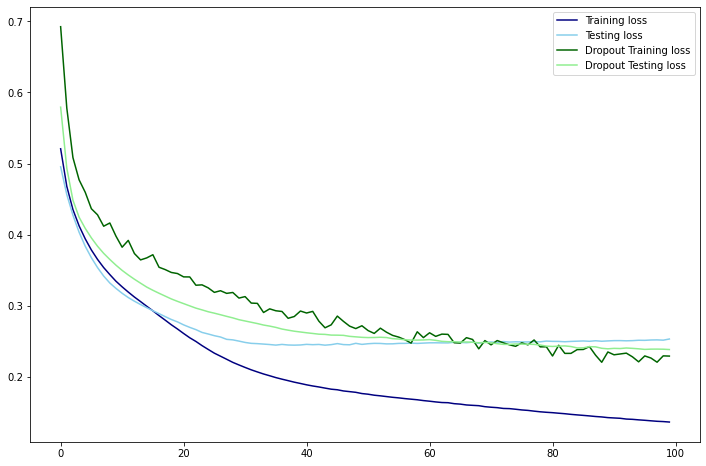

In [26]:
# Visualize loss
train_loss_dropout = results_dropout.history['loss']
test_loss_dropout = results_dropout.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_dropout, label='Dropout Training loss', color='darkgreen')
plt.plot(test_loss_dropout, label='Dropout Testing loss', color='lightgreen')
plt.legend();

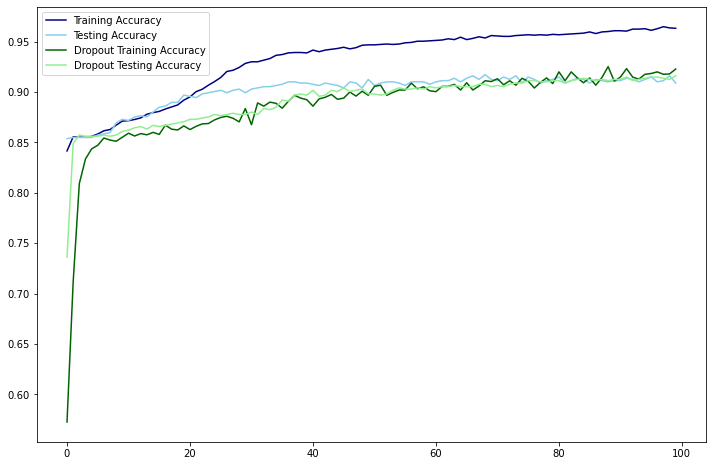

In [27]:
# Visualize accuracy
train_acc_dropout = results_dropout.history['acc']
test_acc_dropout = results_dropout.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Accuracy', color='navy')
plt.plot(test_acc, label='Testing Accuracy', color='skyblue')
plt.plot(train_acc_dropout, label='Dropout Training Accuracy', color='darkgreen')
plt.plot(test_acc_dropout, label='Dropout Testing Accuracy', color='lightgreen')
plt.legend();

In [28]:
## What was our final training and testing accuracy?
results_dropout.history['acc'][-1], results_dropout.history['val_acc'][-1]

(0.9227691292762756, 0.9160671234130859)

**A note about evaluating models with dropout:**
> Since dropout is only used while the model is being trained, when comparing training and testing metrics (loss, accuracy, etc.) you will want to evaluate the model's training performance without dropout.

In [29]:
model_dropout.evaluate(X_train_sc, y_train)

79/79 [==============================] - 0s 1ms/step - loss: 0.1842 - acc: 0.9392


[0.18422262370586395, 0.9391756653785706]

In [30]:
model_dropout.evaluate(X_test_sc, y_test)

27/27 [==============================] - 0s 1ms/step - loss: 0.2386 - acc: 0.9161


[0.23864182829856873, 0.9160671234130859]

## Keras Resources
- [Keras Dropout Documentation](https://keras.io/layers/core/#dropout)

## Tensorflow Resources
- [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)
- [List of examples in Tensorflow](https://programtalk.com/python-examples/tensorflow.nn.dropout/)

### Deep Learning week is also Memes week!
![](../assets/thanos-dropout.png)

<a id='stopping'></a>
## Regularization Method 3: Early Stopping
---
The third method of regularization that we'll discuss today is called early stopping.
</br>
If we run though all our epochs of training and plot both our training and validation error, we'll typically see something like this:

![](../assets/train-val-error-reduced.png)
*source*: [Prechelt, 1997](http://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf)

<details><summary>What is happening in this plot?</summary>

- The Validation error begins to increase after a certain number of epochs!
</details>

Early stopping does exactly what its name implies: it stop the training process early. Instead of continuing training through every epoch, once the validation error begins to increase, our algorithm stops because it has (in theory) found the minimum for the validation loss.

This might seem like a simple and robust solution to overfitting, but it can run into problems.

![](../assets/validation-error-real.png)

There is debate over how often this problem occurs. You can generally plot both the training and validation loss, see if you're getting multiple optima. If you are, there are multiple suggested techniques to combat this problem in the [paper reference above](http://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf).

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
# Build model using early stopping
# Model
model_es = Sequential()

model_es.add(Dense(32, input_shape=X_train_sc[0].shape,activation='relu'))
model_es.add(Dense(16, activation='relu'))
model_es.add(Dense(1, activation='sigmoid'))

# Compile it
model_es.compile(loss='bce', optimizer='adam', metrics=['acc'])

early_stop = EarlyStopping(patience=5)

# Fit it
results_es = model_es.fit(X_train_sc, y_train, 
                          validation_data=(X_test_sc, y_test),
                         epochs=100, batch_size=256,
                         verbose=0,
                         callbacks=[early_stop]) # Add the early stop to the model!

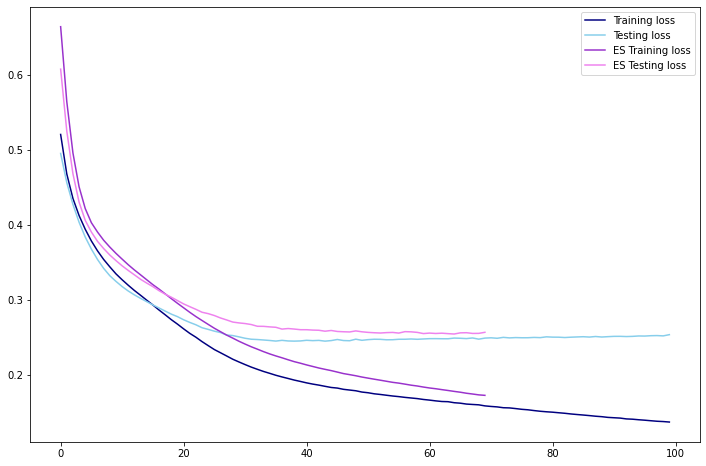

In [33]:
# Visualize loss
train_loss_es = results_es.history['loss']
test_loss_es = results_es.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_es, label='ES Training loss', color='darkorchid')
plt.plot(test_loss_es, label='ES Testing loss', color='violet')
plt.legend();

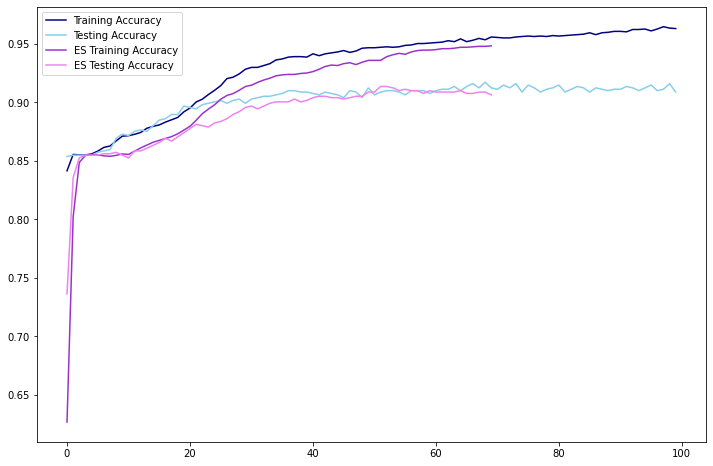

In [34]:
# Visualize accuracy
train_acc_es = results_es.history['acc']
test_acc_es = results_es.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Accuracy', color='navy')
plt.plot(test_acc, label='Testing Accuracy', color='skyblue')
plt.plot(train_acc_es, label='ES Training Accuracy', color='darkorchid')
plt.plot(test_acc_es, label='ES Testing Accuracy', color='violet')
plt.legend();

In [35]:
## What was our final training and testing accuracy?
results_es.history['acc'][-1], results_es.history['val_acc'][-1]

(0.9483793377876282, 0.9064748287200928)

In [36]:
# Build model using early stopping AND restore_best_weights=True!
# Model
model_es_2 = Sequential()

model_es_2.add(Dense(32, input_shape=X_train_sc[0].shape,activation='relu'))
model_es_2.add(Dense(16, activation='relu'))
model_es_2.add(Dense(1, activation='sigmoid'))

# Compile it
model_es_2.compile(loss='bce', optimizer='adam', metrics=['acc'])

early_stop_2= EarlyStopping(patience=5, restore_best_weights=True)

# Fit it
results_es_2 = model_es_2.fit(X_train_sc, y_train, 
                          validation_data=(X_test_sc, y_test),
                         epochs=100, batch_size=256,
                         verbose=0,
                         callbacks=[early_stop_2]) # Add the early stop to the model!

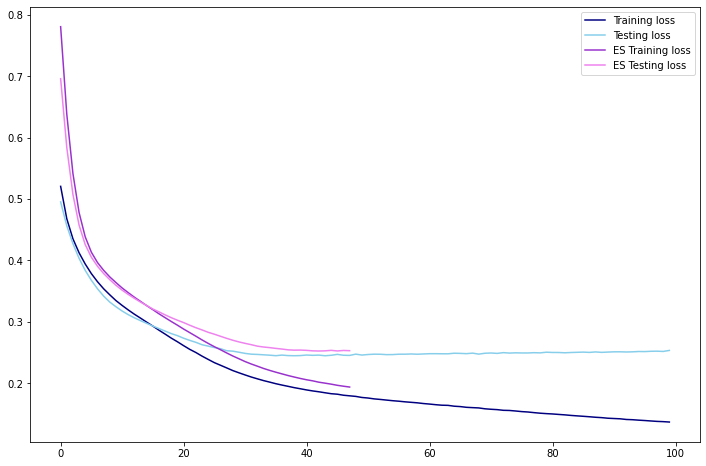

In [37]:
# Visualize loss
train_loss_es_2 = results_es_2.history['loss']
test_loss_es_2 = results_es_2.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_es_2, label='ES Training loss', color='darkorchid')
plt.plot(test_loss_es_2, label='ES Testing loss', color='violet')
plt.legend();

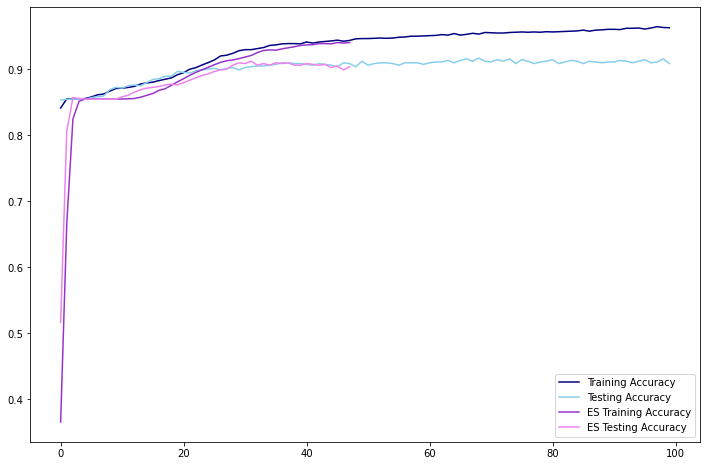

In [38]:
# Visualize Accuracy
train_acc_es_2 = results_es_2.history['acc']
test_acc_es_2 = results_es_2.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Accuracy', color='navy')
plt.plot(test_acc, label='Testing Accuracy', color='skyblue')
plt.plot(train_acc_es_2, label='ES Training Accuracy', color='darkorchid')
plt.plot(test_acc_es_2, label='ES Testing Accuracy', color='violet')
plt.legend();

In [39]:
## What was our final training and testing accuracy?
results_es_2.history['acc'][-1], results_es_2.history['val_acc'][-1]

(0.9407762885093689, 0.9040767550468445)

## Keras Resources
- [Keras EarlyStopping Documentation](https://keras.io/callbacks/#earlystopping)
- [Keras EarlyStopping Example](http://parneetk.github.io/blog/neural-networks-in-keras/)

## Tensorflow Resources
- [Tensorflow.Keras.callbacks.EarlyStopping Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

<a id='conclusion'></a>
# Conclusion

Today, we learned about three different methods of regularizing our neural networks: `L2` regularization, dropout, and early stopping.

## Machine Learning Workflow

As promised, managing bias and variance takes a lot of our attention. If our bias or variance are high, it's likely that our model isn't performing as well as it could.

A workflow for how you should address this (in the context of neural networks and beyond) is as follows:

- Do we have high bias? (i.e. are we performing poorly on our training set?)
    - If so:
        - let's build a more complex model / bigger network!
        - let's consider a new architecture for our neural network!
        - let's train longer!
- Do we have high variance? (i.e. are we performing poorly on our test/holdout set?)
    - If so:
        - let's gather more data!
            - Usually very difficult, but we should use "data augmentation" if we can!
        - let's build a simpler model / smaller network!
        - let's consider a new architecture for our neural network!
        - let's regularize!
    - Once we're satisfied, return to the bias question and repeat.
    
**Note:** Before deep learning, most tools for handling high bias or high variance adversely affected the other. However, depending on the amount of data we have and how complex our network is, it's often the case that we can drastically reduce variance with out affecting bias.

<a id='references'></a>
## References and Resources:

- [DeepLearning.ai](https://www.deeplearning.ai/), Andrew Ng's Coursera course on Deep Learning
  - The videos from this course are on a [YouTube Channel](https://www.youtube.com/channel/UCcIXc5mJsHVYTZR1maL5l9w/featured)   
<br>
- [Deep Learning Book](http://www.deeplearningbook.org/), textbook written by Ian Goodfellow, creator of Generative Adversarial Networks (GANs)